## NIST Genomics PPFL Red Team Exercise
### Introductory tutorial for performing Membership Inference Attack on CNN trained on Soybean Genomics data
#### List of topics covered in this tutorial:
1. [Train Membership Attack Model using Adversarial Robustness Toolkit (ART) library.](#section-1)
2. [Infer Membership Using Trained Attack Model](#section-2)

### Import libraries

In [1]:
import os
from pathlib import Path
import numpy as np
import pickle as pkl
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

import matplotlib.pyplot as plt



from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification import PyTorchClassifier

### Change Current Working Directory (CWD)

In [2]:
print('CWD Before: ', Path.cwd())
# get current working directory
project_dir = 'problem1'

new_cwd = Path.cwd()
if new_cwd.name != project_dir:
    new_cwd = new_cwd.parent

# Set new current working directory path
os.chdir(new_cwd)
print('CWD After: ', Path.cwd())

CWD Before:  /home/rivlanm/projects/nist_ppfl/NIST_PPFL_problem1_202503/problem1/tutorial
CWD After:  /home/rivlanm/projects/nist_ppfl/NIST_PPFL_problem1_202503/problem1


### Utility functions

In [3]:
def load_model(model_path: Path,
               num_data_features: int,
               model_type: str):
    # import model class based on model type
    if model_type == 'cnn':
        from attack_targets.cnn.model import Net
    elif model_type == 'dpcnn':
        from attack_targets.dpcnn10.model import Net
    # init model
    model_class = Net
    # create model instance
    model = model_class(num_data_features) 
    # load model weights
    model.load_state_dict(torch.load(model_path)) 
    model.eval()
    return model

def load_data(data_path: Path):
    data = pkl.load(open(data_path, "rb"))
    features = len(data[0]) - 1
    # get feature (one-hot encoded gene variants) columns
    x = data[:, :features]  
    # get label/class (seed coat color) column
    y = data[:, features] 
    return x, y

def load_hyperparameters(hyperparameters_path: Path):
    with open(hyperparameters_path, 'r') as f:
        hyperparameters = json.load(f)
    return hyperparameters

<a id="section-1"></a>
## 1. [Train Membership Attack Model using Adversarial Robustness Toolkit (ART) library.](#section-1)
[Link to ART Library](https://github.com/Trusted-AI/adversarial-robustness-toolbox)

In this example we train an attack model to attack client 4 from the regular CNN models that have no added privacy.  Note that you should train a new attack model for each client model, and you can change the parameters below to attack different client models from different privacy settings.

To help you test your solution locally, we've also included the answers (the true member records) for client 4 in the competitors pack.  At the end of this notebook, we will show how successful our attack was on the targeted client.

First we will load the client model, and other required files and then train a Membership Inference Attack model using the relevant and external records data. 

The attack model will be trained to infer which of the given challenge records in the cnn_challenge_records file belong to the client 4.

### Program settings and declare paths


#### Client Model 
- these are the client model torch file - learning paramters at the end of federated learning - allow us to initialize model at this state

#### relevant records
- in traditional membership inference attack, these are the records that the attacker is "confident" are records used to train the client model. In our case, the attacker is confident, but not certain, about whether these are true positives
- in training attack model, these are the **true positives**
    - **Question** how sensitive is attack to quality of these

#### external records
- in MI, these are the records the attacker is confidence are NOT in the client training set
- in training attack model, these are the **true negatives**

#### challenge records 
- this is the validation set - records we try to infer membership about for a given client


In [4]:
# Competitor should change these values to train the attack on different client models.
# To attack different clients competitors can change the client_id.  Competitors can change the model_type and privacy_type to test on different privacy levels. Challenge data answers are only provided for client_id 4.

CLIENT_ID = '4'  # or '1', '2', '3'
MODEL_TYPE = 'dpcnn'  # or 'dpcnn'
PRIVACY_TYPE = 'dpcnn200'  # 'cnn' (no privacy), 'dpcnn10' (epsilon 10), dpcnn200 (epsilon 200)

In [6]:
# Set the client id, model type and privacy type to load files for a specific client model
    # e.g. client_id = '4', model_type = 'cnn', privacy_type = 'cnn' --> will load the client 4 model files from cnn models.
    # e.g. client_id = '4', model_type = 'dpcnn', privacy_type = 'dpcnn_epsilon_10' --> will load the client 4 model file from dpcnn_epsilon_10 models.

# Declare required paths:
# Client model directory path
model_dir = Path(f'attack_targets/{PRIVACY_TYPE}/client_{CLIENT_ID}')
# Client model (.torch) path
model_path = Path(model_dir, f'{MODEL_TYPE}_{CLIENT_ID}.torch')
# Path to relevant records data file for the client model
relevant_data_path = Path(model_dir, f'{MODEL_TYPE}_{CLIENT_ID}_relevant_records.dat')
# Path to external records data file for the client model
external_data_path = Path(model_dir, f'{MODEL_TYPE}_{CLIENT_ID}_external_records.dat')
# Path to challenge records data file for the client model
challenge_data_path = Path(model_dir.parent, f'{PRIVACY_TYPE}_challenge_records.dat')
# Path to hyperparameters file for the client model
hyperparameters_path = Path(model_dir, f'{MODEL_TYPE}_{CLIENT_ID}_hyperparameters.json')

### Load data and hyperparameters

In [ ]:
# # These are hyperparameters used for training the client model
# hyperparams = load_hyperparameters(hyperparameters_path)
# # Relevant records are those which an attacker might believe belongs to the client model. See problem statement for details.
# rel_x, rel_y = load_data(relevant_data_path)

# # External records are those which an attacker believes do not belong to the client model. See problem statement for details.
# ext_x, ext_y = load_data(external_data_path)

# # Challenge records are those for which the competitor need to classify. Each challenge record can be classified into 5 categories.
# # If a challenge record belongs to the client model, the competitor should classify it as the client number (1, 2, 3, or 4). Otherwise, the competitor should classify it as 0 which means the record does not belong to any client model in the selected privacy level / privacy type.
# challenge_x, challenge_y = load_data(challenge_data_path)

### Hyperparameters


In [7]:
# These are hyperparameters used for training the client model
hyperparams = load_hyperparameters(hyperparameters_path)
hyperparams

{'batch divisor': 15,
 'delta': 1e-05,
 'epochs': 100,
 'epsilon': 200.0,
 'learning rate': 0.003,
 'max grad norm': 2.0,
 'model id': 4,
 'optimizer': 'sgd',
 'test fraction': 0.3,
 'total classes': 4,
 'weight decay': 0.0001}

# Load data

#### Client 4

**relevant records**
- only 23 records, 125K features D=
- class dist: 0:3, 1:4, 2:14, 3:2

**relevant records**
- 20 records, 125K 
- class dist: 0:5, 1:1, 2:14, 3:2 --> missing class 3

In [8]:
# Relevant records are those which an attacker might believe belongs to the client model. See problem statement for details.
rel_x, rel_y = load_data(relevant_data_path)

print(rel_x.shape)

# class distribution
cl_dist = np.unique(rel_y, return_counts=True)
print(cl_dist[0])
print(cl_dist[1])


(23, 125766)
[0. 1. 2. 3.]
[ 4  2 14  3]


### Let's try to understand what this data is

Questions
- how many one hot encoded was each original feature split into? always 4? it does not appear that way 
- in the original data, Each column represents a gene, and the value of the column indicates whether a given plant’s gene varies from the “default” value. For instance the value “A/T” indicates that the default value of the gene is “A”, but instead this plant has value “T”.


(4, 125766)


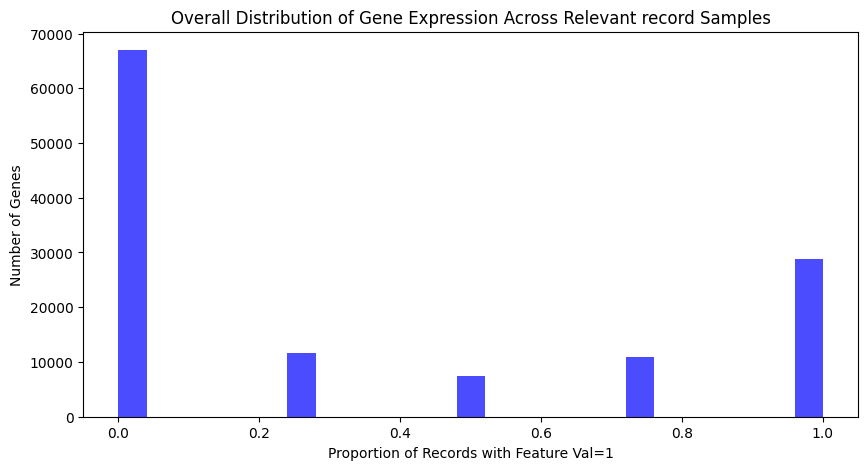

In [9]:
# Assuming `data` is a (23, 125766) numpy array where each column represents a gene
# Compute the proportion of records (samples) where each feature (gene) is active (1)
feature_activation_rates = np.mean(rel_x[rel_y == 0], axis=0)
print(rel_x[rel_y == 0].shape)
# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(feature_activation_rates, bins=25, color="blue", alpha=0.7)
plt.xlabel("Proportion of Records with Feature Val=1")
plt.ylabel("Number of Genes")
plt.title("Overall Distribution of Gene Expression Across Relevant record Samples")
plt.show()


(2, 125766)


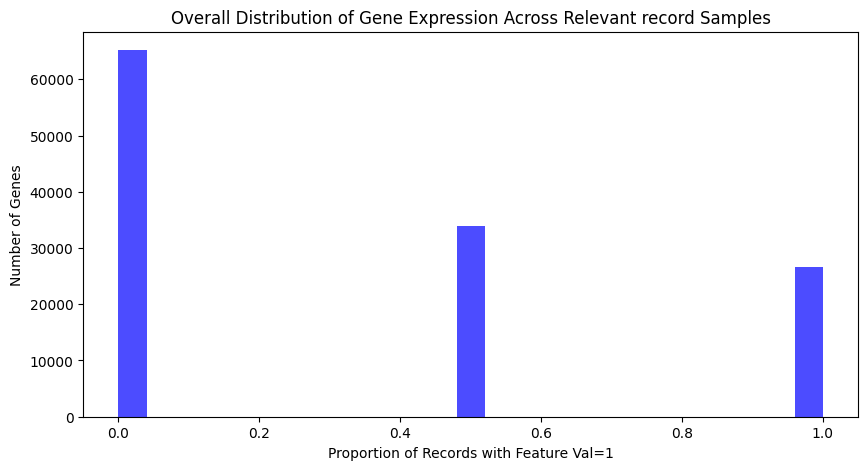

In [10]:
# Assuming `data` is a (23, 125766) numpy array where each column represents a gene
# Compute the proportion of records (samples) where each feature (gene) is active (1)
feature_activation_rates = np.mean(rel_x[rel_y == 1], axis=0)
print(rel_x[rel_y == 1].shape)
# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(feature_activation_rates, bins=25, color="blue", alpha=0.7)
plt.xlabel("Proportion of Records with Feature Val=1")
plt.ylabel("Number of Genes")
plt.title("Overall Distribution of Gene Expression Across Relevant record Samples")
plt.show()


(14, 125766)


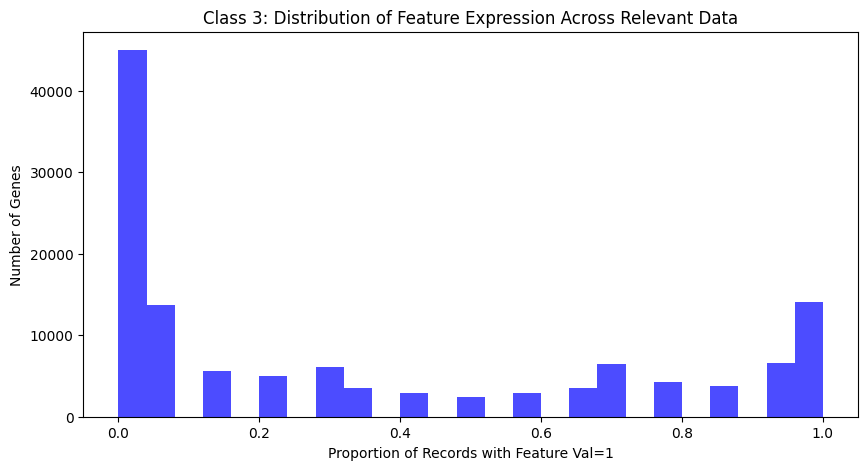

In [26]:
# Assuming `data` is a (23, 125766) numpy array where each column represents a gene
# Compute the proportion of records (samples) where each feature (gene) is active (1)
feature_activation_rates = np.mean(rel_x[rel_y == 2], axis=0)
print(rel_x[rel_y == 2].shape)
# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(feature_activation_rates, bins=25, color="blue", alpha=0.7)
plt.xlabel("Proportion of Records with Feature Val=1")
plt.ylabel("Number of Genes")
plt.title("Class 3: Distribution of Feature Expression Across Relevant Data")
plt.show()


(3, 125766)


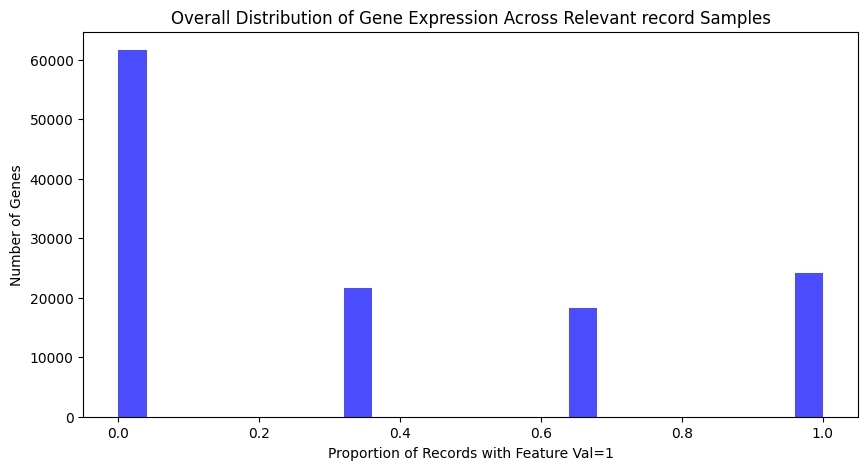

In [12]:
# Assuming `data` is a (23, 125766) numpy array where each column represents a gene
# Compute the proportion of records (samples) where each feature (gene) is active (1)
feature_activation_rates = np.mean(rel_x[rel_y == 3], axis=0)
print(rel_x[rel_y == 3].shape)
# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(feature_activation_rates, bins=25, color="blue", alpha=0.7)
plt.xlabel("Proportion of Records with Feature Val=1")
plt.ylabel("Number of Genes")
plt.title("Overall Distribution of Gene Expression Across Relevant record Samples")
plt.show()


In [13]:
# External records are those which an attacker believes do not belong to the client model. See problem statement for details.
ext_x, ext_y = load_data(external_data_path)
print(ext_x.shape)

# class distribution
cl_dist = np.unique(ext_y, return_counts=True)
print(cl_dist[0])
print(cl_dist[1])

(20, 125766)
[0. 1. 2. 3.]
[ 2  2 12  4]


### Challenge Records 
- If a challenge record belongs to the client model, the competitor should classify it as the client number (1, 2, 3, or 4)..otherwise 0 


In [14]:
# Challenge records are those for which the competitor need to classify. 
#   Each challenge record can be classified into 5 categories.

# If a challenge record belongs to the client model, the competitor should classify it as the client number (1, 2, 3, or 4). 
#   Otherwise, the competitor should classify it as 0 --> which means the record does not belong to any client model in the selected privacy level / privacy type.

print(challenge_data_path)
challenge_x, challenge_y = load_data(challenge_data_path)

print(challenge_x.shape)

# class distribution --> these are the original outcome classes 
cl_dist = np.unique(challenge_y, return_counts=True)
print(cl_dist[0])
print(cl_dist[1])

attack_targets/dpcnn200/dpcnn200_challenge_records.dat
(73, 125766)
[0. 1. 2. 3.]
[15  5 50  3]


### Load client task model

#### CNN:
- Total Model Size: ~673 MB (heavy for a 1D CNN).
- High Memory Use: Forward/backward passes take ~625 MB.
- the fully connected layers seem to be a major bottleneck.
- **architecture**
    - First 1-D CNN maps size 10 kernel is used to capture basic low-level features 
        - we know the number of kernels given the output shape of 1st conv1d layer --> [73, 10, 125757]  
        - we know the size of 1d kernel is 10 given the difference between input shape (125766) and output shape (125757)
    - Second 1-D CNN has kernel size 8 and stride 1, reduces number of channels from 10 to 8 
- **Questions**
    - is it worth understanding where the first 1d Conv layer's kernels tend to activate (what low level patters are they learning)?


In [15]:
task_model = load_model(model_path, rel_x.shape[1], MODEL_TYPE)


In [16]:
summary(task_model, input_size=(challenge_x.shape[0], 1, 125766))


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [73, 4]                   --
├─Conv1d: 1-1                            [73, 10, 125757]          110
├─ReLU: 1-2                              [73, 10, 125757]          --
├─Dropout: 1-3                           [73, 10, 125757]          --
├─Conv1d: 1-4                            [73, 8, 125750]           648
├─Dropout: 1-5                           [73, 8, 125750]           --
├─Conv1d: 1-6                            [73, 6, 125745]           294
├─MaxPool1d: 1-7                         [73, 6, 62872]            --
├─LayerNorm: 1-8                         [73, 6, 62872]            754,464
├─Linear: 1-9                            [73, 24]                  9,053,592
├─Linear: 1-10                           [73, 16]                  400
├─Linear: 1-11                           [73, 4]                   68
├─LayerNorm: 1-12                        [73, 4]                   8


In [ ]:
# size of conv1d kernel 
print(task_model.conv1.weight.shape)
# first droput
print(task_model.dropout1.p)
# second conv1d
print(task_model.dropout2.p)

print(task_model.conv2.weight.shape)


torch.Size([10, 1, 10])
0.2
0.1
torch.Size([8, 10, 8])


In [18]:
task_model

Net(
  (conv1): Conv1d(1, 10, kernel_size=(10,), stride=(1,))
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv1d(10, 8, kernel_size=(8,), stride=(1,))
  (dropout2): Dropout(p=0.1, inplace=False)
  (conv3): Conv1d(8, 6, kernel_size=(6,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ln1): LayerNorm((6, 62872), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=377232, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=4, bias=True)
  (ln2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
)

# ============================================
# Initialized membership attack model
# ============================================


In [19]:
# Define loss and other required hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer_name = hyperparams['optimizer']
learning_rate = hyperparams['learning rate']
weight_decay = hyperparams['weight decay']
num_classes = hyperparams['total classes']

print("optimizer", optimizer_name)
print("learning_rate", learning_rate)
print("weight_decay", weight_decay)
# number of classes here refers to the soybean classes
print("num_classes", num_classes)

optimizer sgd
learning_rate 0.003
weight_decay 0.0001
num_classes 4


In [ ]:
# Wrap client model in the ART PyTorch classifier

# Select optimizer
if optimizer_name == 'sgd':
    optimizer = optim.SGD(task_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
else:
    optimizer = optim.Adamax(task_model.parameters(), lr=learning_rate,  weight_decay=weight_decay)

# Wrap client model in PyTorchClassifier
classifier = PyTorchClassifier(
    model=task_model,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(rel_x.shape[1],),
    nb_classes=num_classes
    )

# Membership Inference Attack model hyperparameters
attack_model_type = 'nn'
attack_model_epochs = 100
attack_model_batch_size = 100
attack_model_learning_rate = 0.03

# Create Membership Inference Black Box attack object
attack_model = MembershipInferenceBlackBox(
    # this is an initialized version of Client N's classification model
    classifier,
    # attack model will be a nn
    attack_model_type=attack_model_type,
    # 100
    nn_model_epochs=attack_model_epochs,
    # 100
    nn_model_batch_size=attack_model_batch_size,
    # 0.03
    nn_model_learning_rate=attack_model_learning_rate
)

### Train membership attack model

In [ ]:
# Get client model's predictions on relevant and external data
rel_x_preds = task_model(rel_x).squeeze()
ext_x_preds = task_model(ext_x).squeeze()
rel_x_preds = rel_x_preds.detach().numpy()
ext_x_preds = ext_x_preds.detach().numpy()

# Train attack model by passing relevant set as x and external set as test_x
attack_model.fit(
    # features from relevant records 
    x=rel_x,
    # outcome (soybean class) labels from relevant records
    y=rel_y,
    # features from external records
    test_x=ext_x,
    # outcome (soybean class) labels from external records
    test_y=ext_y,
    # prediction (logits) from pre trained classifier (for a given client) on relevant records 
    pred=rel_x_preds,
    # prediction (logits) from pre trained classifier (for a given client) on external records 
    test_pred=ext_x_preds
)

<a id="section-2"></a>
## 2. [Infer Membership Using Trained Attack Model](#section-2)
In this section we first check the trained attack model's membership predictions on the relevant and external data (Inference and Performance of Attack Model).  Remember from the problem statement: we know that none of the external records are members of the targeted client's training data.   But because the attacker's knowledge is realistically imperfect, the relevant records contain a mix of true member records and other records.  Ideally the attack model should predict that none of the external records are members, and it should predict that only the true members in the relevant records are members.

Next we get the attack model's predictions for the challenge records (Attack Predictions on Challenge Records).  This produces a list of the indices of the challenge records that the attack model believes belong to the targeted client_id.  Note that when you repeat this process to  train different attack models for different clients, their predictions may have conflicts you'll need to resolve.  If client 3 and client 4 both believe that challenge record 37 is a member of their training data, you'll need to decide which client to assign the record to.

Finally, we've provided the true answers for client 4, so if client_id = 4 we can check the attack model's predictions for it against the ground truth (Confirm Answers for Public Demonstration Model). The challenge_members file contains the challenge records that belong to client 4, and the relevant_members file contains the relevant records that belong to client 4.  Note that the ART model's performance isn't as good as it could be.  There's a very good chance you can find, create or configure an attack model that does better.

### Inference and performance of attack model


- we don't mess up at all on the external records (by incorrectly inferring membership) nor on the relevant records (by incorrectly NOT inferring membership)

In [22]:
# Infer membership on relevant and external data
atk_rel_preds = attack_model.infer(x=rel_x, y=rel_y)
atk_ext_preds = attack_model.infer(x=ext_x, y=ext_y)

# external data for an attack model only has non-members records.
# Find the number of non-members predicted by the attack model
external_correct = np.sum((atk_ext_preds == 0))

# Calculate accuracy on external data
external_accuracy = external_correct / len(atk_ext_preds)

print('Attack Model Accuracy on External Data: ', round(external_accuracy, 2))

Attack Model Accuracy on External Data:  1.0


In [23]:
# Find number of relevant records that are predicted as members by the attack model

relevant_predicted_members = np.sum((atk_rel_preds == 1))
print('Number of records predicted as members in relevant data: ', relevant_predicted_members)
print('Total Relevant Records: ', len(atk_rel_preds))

Number of records predicted as members in relevant data:  22
Total Relevant Records:  23


### Attack model predictions on challenge records

In [24]:
# Find indices of challenge data records that are predicted as members by the attack model
challenge_pred = attack_model.infer(x=challenge_x, y=challenge_y)
challenge_members_indices = np.where(challenge_pred.squeeze() == 1)[0]
print('Indices of Challenge Data Records predicted as members: \n', challenge_members_indices)

Indices of Challenge Data Records predicted as members: 
 [ 1  2 10 13 16 17 19 20 22 24 25 27 30 32 43 44 45 48 50 52 54 55 56 57
 58 59 60 65 66 67 68 70 71 72]


Note on Data Submission:

The list above contains the indices of the challenge records that the attack model has identified as potential members of the client_id task model. If you believe these indices correspond to actual member records of the tested client model, you should enter it as your prediction for that challenge record in the problem's submission_file.

The submission file consists of two columns: the first column is the challenge record index, and the second column is the prediction. If you believe the record was a member of some client's training data, enter the client number (1, 2, 3, 4) . However, if you determine that a challenge data index does not belong to any client model, enter '0' as the prediction for that index.

### Confirm Answers for Public Demonstration Model


In [25]:
if CLIENT_ID == '4':
    # load challenge data answers for client 4

    # Challenge data members are indices of the challenge records of the client model
    challenge_members_path = Path(model_dir, f'{MODEL_TYPE}_{CLIENT_ID}_challenge_members.json')
    
    # Relevant members are indices of the relevant records that are actual members of the client model
    relevant_members_path = Path(model_dir, f'{MODEL_TYPE}_{CLIENT_ID}_relevant_members.json')

    # Load Challenge member indices and relevant member indices
    with open(challenge_members_path, 'r') as f:
        challenge_members_dict = json.load(f)
    challenge_members = list(challenge_members_dict['challenge members'])
    print("number of positive instances among challenge members: {}".format(len(challenge_members)))

    with open(relevant_members_path, 'r') as f:
        relevant_members_dict = json.load(f)
    relevant_members = list(relevant_members_dict['relevant members'])
    print("number of positive instances among relevant_members: {}".format(len(relevant_members)))

    # =====================================================
    # RELEVANT DATA

    # Get true client 4 member in relevant data
    true_client_4_members_x = rel_x[relevant_members]
    true_client_4_members_y = rel_y[relevant_members]

    print('Percentage of True Client 4 Members that Attack Model predicted as Members --> (Recall)')
    # Infer membership on true client 4 members
    preds = attack_model.infer(x=true_client_4_members_x, y=true_client_4_members_y)
    # print(preds)
    true_members_correct = np.sum((preds == 1))

    # Calculate percentage of predicting true members as members by the attack model
    true_members_percentage = (true_members_correct / len(preds)) * 100
    print('Positive Class Recall In Relevant Records: ', f'{round(true_members_percentage, 2)}%')

    # =====================================================
    # Get true client 4 members in challenge data
    true_client_4_members_x = challenge_x[challenge_members]
    true_client_4_members_y = challenge_y[challenge_members]

    # Infer membership on true client 4 members
    preds = attack_model.infer(x=true_client_4_members_x, y=true_client_4_members_y)
    true_members_correct = np.sum((preds == 1))

    # print('Among Challenge Data --> Percentage of True Client 4 Members that Attack Model predicted as Members --> (Recall)')

    # Calculate percentage of predicting true members as members by the attack model
    true_members_percentage = (true_members_correct / len(preds)) * 100
    print('Positive Class Recall In Challenge Records: ', f'{round(true_members_percentage, 2)}%')

    # =====================================================
    print('Percentage of True Client 4 Non-members that Attack Model predicted as Non-members')
    # Get true client 4 non-members in relevant data
    non_member_indices = list(set(range(rel_x.shape[0])) - set(relevant_members))
    true_client_4_non_members_x = rel_x[non_member_indices]
    true_client_4_non_members_y = rel_y[non_member_indices]

    # Infer membership on true client 4 non-members
    preds = attack_model.infer(x=true_client_4_non_members_x, y=true_client_4_non_members_y)
    true_non_members_correct = np.sum((preds == 0))

    # Calculate percentage of predicting true non-members as non-members by the attack model
    true_non_members_percentage = (true_non_members_correct / len(preds)) * 100
    print('Negative Class Recall: In Relevant Records: ', f'{round(true_non_members_percentage, 2)}%')

    # =====================================================
    # Get true client 4 non-members in challenge data
    non_member_indices = list(set(range(challenge_x.shape[0])) - set(challenge_members))
    true_client_4_non_members_x = challenge_x[non_member_indices]
    true_client_4_non_members_y = challenge_y[non_member_indices]

    # Infer membership on true client 4 non-members
    preds = attack_model.infer(x=true_client_4_non_members_x, y=true_client_4_non_members_y)
    true_non_members_correct = np.sum((preds == 0))
    # Calculate percentage of predicting true non-members as non-members by the attack model
    true_non_members_percentage = (true_non_members_correct / len(preds)) * 100
    print('Negative Class Recall: In Challenge Records: ', f'{round(true_non_members_percentage, 2)}%')
else:
    print('Error: Membership answers are only provided for client 4. Your client_id is set to:', CLIENT_ID)

number of positive instances among challenge members: 2
number of positive instances among relevant_members: 11
Percentage of True Client 4 Members that Attack Model predicted as Members --> (Recall)
Positive Class Recall In Relevant Records:  100.0%
Positive Class Recall In Challenge Records:  50.0%
Percentage of True Client 4 Non-members that Attack Model predicted as Non-members
Negative Class Recall: In Relevant Records:  8.33%
Negative Class Recall: In Challenge Records:  53.52%


### Next Steps

- We've just trained an ART attack model for client 4 in the CNN models.  Well done!

- Once you've trained an attack model for every client, you can decide on a final membership prediction for every challenge record in the cnn_challenge_records.dat: Predicting client 1, 2, 3, 4 or use 0 for records that are not a member of any client's training data. Enter these predictions into the cnn_submision_file.csv.

- Does differential privacy make your attacks less successful? 
    - Change the configuration at the top of the notebook to try out this process for the the dpcnn10 and dpcnn200 models. 

- Once you've made your predictions for all three cases (using each case's challenge_records and submission_files), you can submit your attack using the google form on the website's Submit tab.

- But this notebook just shows one configuration of the ART library. To encourage you to try out different attack approaches and configurations, your team can submit *up to three entries* for each leaderboard update (see Submit tab for details). 
    - You'll only be scored on your most successful attack, but we'll use all your submissions to understand our research problems better. Look through our Resources tab for links to a wide variety of libraries and reference ideas you can try out. See what works and what doesn't, and what's just weird.

Have fun!   And thank you for helping us learn about privacy protection to support collaborative research on genomic data.

### Notes

- each model is trained to a specific client model - predicting membership in that particular client model

- first goal is to predict the correct membership labels among the **"relevant records"**
    - we trained on these as if they were all "true" members 

- second goal is to predict correct membeship among  

